<font size=25, color='#ED1F24'>Assigment 2 - Convolutional Networks

Import necessary libraries

In [486]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from random import sample

from IPython.core.debugger import set_trace

import sklearn
import captum


C:\Users\Fabi\anaconda3\envs\tema1_rna\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set the parameters for training

In [2]:
lr = 0.001
momentum = 0.9
num_epochs = 5
batch_size = 8
num_cls = 10

Load **CIFAR-10** dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./ds', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [0.8, 0.2])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
validloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./ds', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

assert len(trainset) == 40000
assert len(valset) == 10000
assert len(testset) == 10000

# **TASK 1**. Classification task

## **Task 1.1** Define a standard convolutional network

In [203]:
class SimpleConvNet(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(5, 5), padding=2) #P = (F-1)/2
        self.activation_fn = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5,5), padding=2) 
        self.fc1 = nn.Linear(in_features=16*8*8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=out_size)
        # TODO

    def forward(self, x):
        #TODO
        x = self.conv1(x)
        x = self.activation_fn(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.activation_fn(x)
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.activation_fn(x)
        x = self.fc2(x)
        x = self.activation_fn(x)
        x = self.fc3(x)
        return x

net = SimpleConvNet(out_size=num_cls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

## **Task 1.2.** Training and evaluation

In [5]:
def validate(model, loss_fn, device):
    model.eval()
    y_pred = []
    y_true = []
    total_loss = 0
    n_predictions = 0

    with torch.no_grad():
        for X, y in validloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            
            batch_size = X.size(0)
            total_loss += loss.item() * batch_size
            n_predictions += batch_size
            
            outputs = torch.argmax(outputs, dim=1)
            y_pred.extend(outputs.cpu().numpy())
            y_true.extend(y.cpu().numpy())
    
    average_loss = total_loss / n_predictions
    return y_pred, y_true, average_loss, sklearn.metrics.accuracy_score(y_true, y_pred)

In [6]:
def train_epoch(model, optimizer, loss_fn, device):
    model.train()
    y_true = []
    y_pred = []
    total_loss = 0
    n_predictions = 0

    for X, y in trainloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        outputs = model(X)
        loss = loss_fn(outputs, y)
        
        loss.backward()
        optimizer.step()
        
        batch_size = X.size(0)
        total_loss += loss.item() * batch_size
        n_predictions += batch_size
        
        outputs = torch.argmax(outputs, dim=1)
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(y.cpu().numpy())
    
    average_loss = total_loss / n_predictions
    
    _, _, val_loss, val_accuracy = validate(model, loss_fn, device)
    
    return average_loss, sklearn.metrics.accuracy_score(y_true, y_pred), val_loss, val_accuracy

In [7]:
def train_loop(n_epochs, net, optimizer, loss_fn):
    hist_train_loss = []
    hist_train_acc = []
    hist_val_loss = []
    hist_val_acc = []
    for epoch in range(num_epochs):
        train_loss, train_acc, val_loss, val_acc = train_epoch(net, optimizer, loss_fn, device)
        print(f'Tran loss = {train_loss} | train acc = {train_acc} | val loss = {val_loss} | val acc = {val_acc}')
        hist_train_loss.append(train_loss)
        hist_train_acc.append(train_acc)
        hist_val_loss.append(val_loss)
        hist_val_acc.append(val_acc)
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(hist_train_loss, label='Training Loss')
    plt.plot(hist_val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(hist_train_acc, label='Training Accuracy')
    plt.plot(hist_val_acc, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Tran loss = 1.9254000704884529 | train acc = 0.286775 | val loss = 1.5555539547443389 | val acc = 0.4302
Tran loss = 1.4131044578671454 | train acc = 0.490825 | val loss = 1.2574193930387496 | val acc = 0.5492
Tran loss = 1.1941515031725167 | train acc = 0.571075 | val loss = 1.1266889802217483 | val acc = 0.5988
Tran loss = 1.0567439066171647 | train acc = 0.623575 | val loss = 1.0419912514567375 | val acc = 0.6295
Tran loss = 0.9509808152541518 | train acc = 0.66235 | val loss = 1.0387805050313472 | val acc = 0.6311


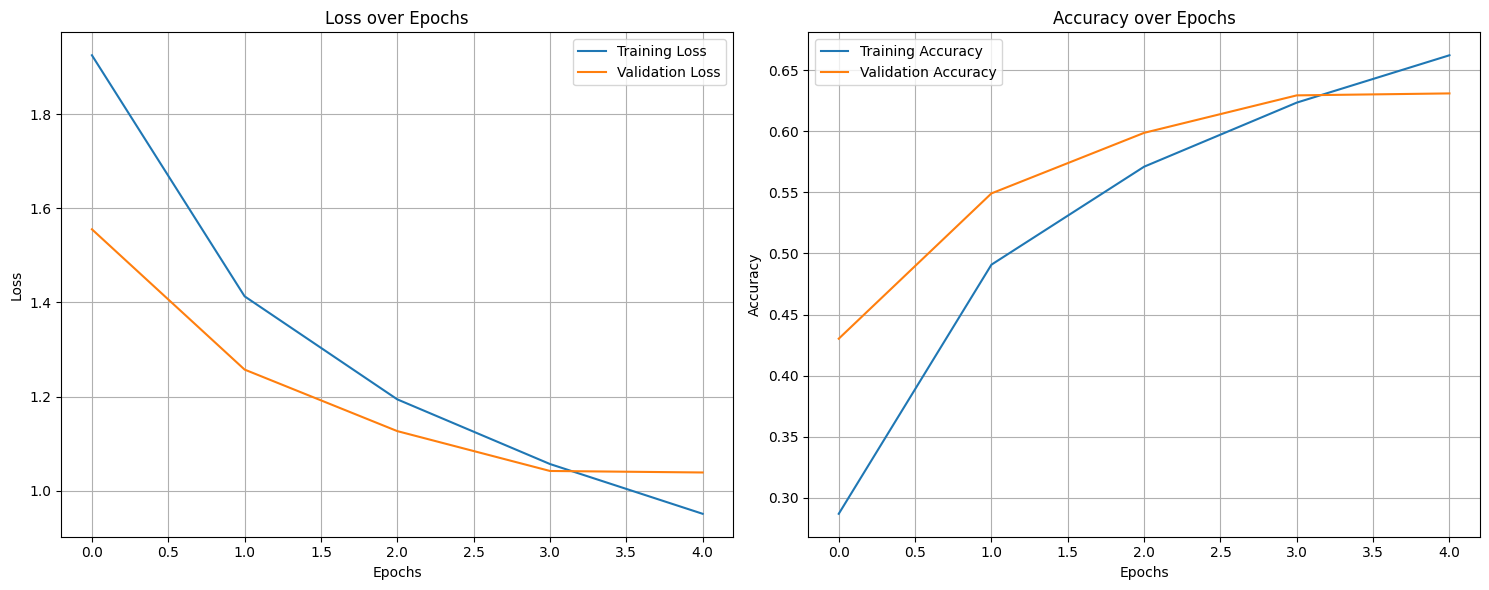

In [204]:
optimizer = torch.optim.SGD(params= net.parameters(), lr=lr, momentum=momentum)
loss_fn = torch.nn.CrossEntropyLoss()

train_loop(num_epochs, net, optimizer, loss_fn)

# **TASK 2**. Implement a fully connected layer

## **Task 2.1.** Implement Linear layer

In [289]:
import math
import pdb
class myLinear(nn.Module):
    def __init__(self, in_features, out_features, device=None):
        super().__init__()
        self.in_features = in_features # 8 
        self.out_features = out_features # 16
        # initialise parameters
        # weight shape: [in, out]
        # bias shape: [out]
        
        self.weight = torch.nn.parameter.Parameter(
            torch.empty(out_features, in_features, device=device)
        )
        self.bias = torch.nn.parameter.Parameter(
            torch.empty(out_features, device=device)
        )
        
        self.reset_parameters()
    
    def reset_parameters(self):
        self.scale = 1.0 / math.sqrt(self.in_features)
        nn.init.uniform(self.weight, -self.scale, self.scale)
        nn.init.uniform_(self.bias, -self.scale, self.scale)

    def forward(self, x):
    # weight shape: [out, in]
    # x shape: [batch, in]
    # we want do matrix multiplication between the weight and each element in the batch x[i] (seen as a column vector)
    # y[i] = W x[i]
    
    # in order to do this we rely on broadcasting in torch.matmul and must reshape x as [batch, in , 1]
    # such that the matrix multiplication is done on dimmensions [out, in] [in, 1] -> [out, 1]
    # (https://pytorch.org/docs/stable/generated/torch.matmul.html)
        x = torch.reshape(x, (x.size(0), x.size(1), 1))

    # TODO
    # compute the linear operation using torch.matmul
    # y = ...
        y = torch.matmul(self.weight, x)
    
    # we add the same bias column vector to each element in the batch y[i] = y[i] + bias
    # we rely again on broadcasting and make the bias have dimension [1, out, 1]
    # such that it aligns with y of shape [batch, out, 1]
        bias_reshaped = torch.reshape(self.bias, (1, self.out_features, 1))
    
    # TODO add bias
    # y = ...
        y = y + bias_reshaped
        return y.squeeze() # so that it is (batch_size, out_features) and not (batch_size, out_features, 1)


In [299]:
my_linear = myLinear(8, 16, device=device)
linear = nn.Linear(8, 16, device=device)
my_linear.load_state_dict(linear.state_dict())

C:\Users\Fabi\AppData\Local\Temp\ipykernel_31620\2329485291.py:23: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  nn.init.uniform(self.weight, -self.scale, self.scale)


<All keys matched successfully>

In [301]:
input_tensor = torch.rand((batch_size, 8)).to(device)
output_linear = linear.forward(input_tensor)
output_my_linear = my_linear.forward(input_tensor)

In [302]:
diff = output_linear - output_my_linear
diff.sum()

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

# **TASK 3.** Implement a convolutional layer

## **Task 3.1.** Implement Conv2d layer

In [308]:
def convolution(image, kernel, device):
    image = image.to(device)
    kernel = kernel.to(device)
    
    in_height, in_width = image.shape
    kernel_height, kernel_width = kernel.shape
    out_height = in_height - kernel_height + 1
    out_width = in_width - kernel_width + 1
    result = torch.zeros((out_height, out_width))
    for i in range(out_height):
        for j in range(out_width):
          image_crop = image[i:i+kernel_height, j:j+kernel_width]
          result[i,j] = torch.dot(image_crop.reshape(-1), kernel.reshape(-1))
    
    return result

In [346]:
class myConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, device=None):
        super(myConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.device = device
        
        # initialise parameters
        scale = 1.0 / math.sqrt(in_channels * kernel_size * kernel_size)
        self.weight = torch.nn.parameter.Parameter(
            torch.rand(out_channels, in_channels, kernel_size, kernel_size, device=device)
        )
        self.bias = torch.nn.parameter.Parameter(
            torch.rand(out_channels, device=device)
        )
        self.reset_parameters()

    def reset_parameters(self):
        self.scale = 1.0 / math.sqrt(self.in_channels * self.kernel_size * self.kernel_size )
        nn.init.uniform(self.weight, -self.scale, self.scale)
        nn.init.uniform_(self.bias, -self.scale, self.scale)

    def forward(self, x):
        x = x.to(self.device)
        bias = self.bias.to(device)
        # print(x.shape)
        x = torch.nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding), 'constant', 0)
        # print(x.shape)
        batch_out = []
        for i in range(x.shape[0]):# for each batch
            out_cube = []
            for kernel_filter in self.weight:# for each filter (out_channels filters)
                out_matrix = None
                for channel_index in range(kernel_filter.shape[0]):
                    result = convolution(x[i][channel_index], kernel_filter[channel_index], self.device)
                    if out_matrix == None:
                        out_matrix = result
                    else:
                        out_matrix += result
                out_cube.append(out_matrix.to(device))
                # print(out_matrix.shape)
            # print(len(out_cube))
            out_cube = torch.stack(out_cube).to(self.device)
            # print(out_cube.shape)
            out_cube += bias.view(-1, 1, 1)
            # print(type(out_cube))
            batch_out.append(torch.Tensor(out_cube))
        
        # TODO
        
        return torch.stack(batch_out)


In [319]:
conv = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(5, 5), padding=2, device=device)
my_conv = myConv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2, device=device)
my_conv.load_state_dict(conv.state_dict())
input_image = torch.rand((8, 3, 32, 32)).to(device)
output_conv = conv.forward(input_image)
output_my_conv = my_conv.forward(input_image)

C:\Users\Fabi\AppData\Local\Temp\ipykernel_31620\1182494140.py:22: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  nn.init.uniform(self.weight, -self.scale, self.scale)


In [320]:
torch.abs(output_conv - output_my_conv).mean().item()

3.424031547183404e-08

## **Task 3.2.** Evaluate your implementation of convolutional network.

In [347]:
class mySimpleConvNet(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        self.conv1 = myConv2d(in_channels = 3, out_channels = 8, kernel_size = 5, padding = 2)
        self.activation_fn = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = myConv2d(in_channels= 8, out_channels = 16, kernel_size = 5, padding = 2)
        self.fc1 = myLinear(in_features=16 * 8 * 8, out_features = 128)
        self.fc2 = myLinear(in_features = 128, out_features = 64)
        self.fc3 = myLinear(in_features = 64, out_features = out_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation_fn(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.activation_fn(x)
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.activation_fn(x)
        x = self.fc2(x)
        x = self.activation_fn(x)
        x = self.fc3(x)
        return x


my_net = mySimpleConvNet(out_size=num_cls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_net = my_net.to(device)


C:\Users\Fabi\AppData\Local\Temp\ipykernel_31620\2955536346.py:22: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  nn.init.uniform(self.weight, -self.scale, self.scale)
C:\Users\Fabi\AppData\Local\Temp\ipykernel_31620\2329485291.py:23: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  nn.init.uniform(self.weight, -self.scale, self.scale)


In [348]:
import timeit
timeit.default_timer()
def validate_short(model, device):
    model.eval()
    y_pred = []
    y_true = []
    n_predictions = 0

    total_time = 0

    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device), y.to(device)

            time_before = timeit.default_timer()
            outputs = model(X)
            time_after = timeit.default_timer()
            total_time += (time_after - time_before)
            
            batch_size = X.size(0)
            n_predictions += batch_size
            
            outputs = torch.argmax(outputs, dim=1)
            y_pred.extend(outputs.cpu().numpy())
            y_true.extend(y.cpu().numpy())
            if n_predictions >= 21:
                break
    
    return y_pred, y_true, sklearn.metrics.accuracy_score(y_true, y_pred), total_time / n_predictions

In [349]:
my_net.load_state_dict(net.state_dict())

<All keys matched successfully>

In [350]:
_, _, acc_net, time_net = validate_short(net, device)
_, _, acc_my_net, time_my_net = validate_short(my_net, device)

In [358]:
print(f'Average time for inference, torch model = {time_net} | Average time for inference, personal model = {time_my_net} | Pytorch model is {int(time_my_net / time_net)} times faster')

Average time for inference, torch model = 5.509583335575977e-05 | Average time for inference, personal model = 9.791490458333291 | Pytorch model is 177717 times faster


## **Task 3.3.** Feature map visualization

In [394]:
class VisualziedConvNet(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(5, 5), padding=2) #P = (F-1)/2
        self.activation_fn = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5,5), padding=2) 
        self.fc1 = nn.Linear(in_features=16*8*8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=out_size)
        # TODO

    def forward(self, x):
        #TODO
        x = self.conv1(x)
        x = self.activation_fn(x)
        img_1 = x[0, :5]
        x = self.max_pool(x)
        img_2 = x[0, :5]
        x = self.conv2(x)
        x = self.activation_fn(x)
        img_3 = x[0, :5]
        x = self.max_pool(x)
        img_4 = x[0, :5]
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.activation_fn(x)
        x = self.fc2(x)
        x = self.activation_fn(x)
        x = self.fc3(x)
        return img_1, img_2, img_3, img_4

viz_net = VisualziedConvNet(out_size=num_cls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
viz_net = viz_net.to(device)
viz_net.load_state_dict(net.state_dict())

<All keys matched successfully>

In [413]:
def minmax(images):
    minim = images.min(axis=(1, 2), keepdims=True)
    maxim = images.max(axis=(1, 2), keepdims=True)
    images = (images - minim) / (maxim - minim)
    return images

In [490]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

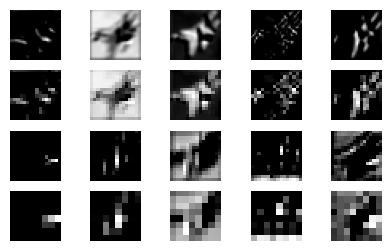

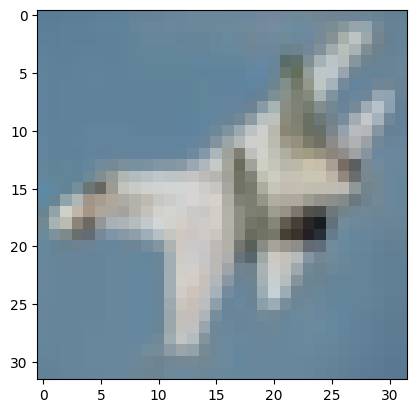

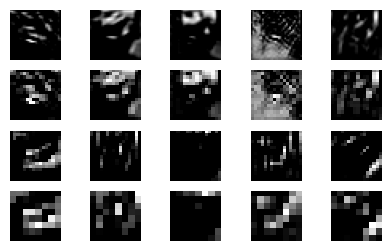

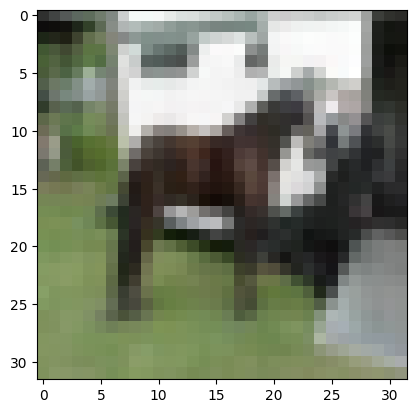

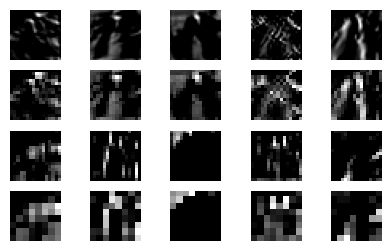

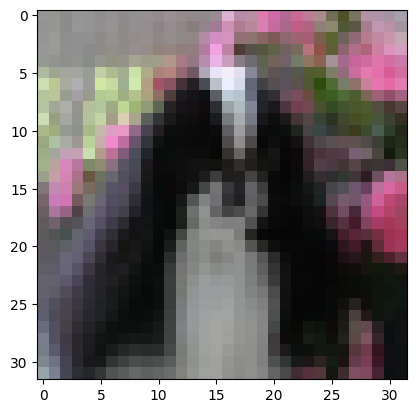

In [493]:
def show_feature_map_image(img):
    img_1, img_2, img_3, img_4 = viz_net.forward(img.unsqueeze(dim=0))
    img_1, img_2, img_3, img_4 = img_1.detach().cpu().numpy(), img_2.detach().cpu().numpy(), img_3.detach().cpu().numpy(), img_4.detach().cpu().numpy()
    img_1, img_2, img_3, img_4 = minmax(img_1), minmax(img_2), minmax(img_3), minmax(img_4)

    fig, axes = plt.subplots(4, 5, figsize=(5, 3))
    axes = axes.ravel()

    images = list(img_1) + list(img_2) + list(img_3) + list(img_4)
    for i in range(len(images)):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')

    plt.show()

    imshow(img.detach().cpu())

img1 = testset[10][0]
img1 = img1.to(device)
img2 = testset[20][0]
img2 = img2.to(device)
img3 = testset[42][0]
img3 = img3.to(device)
show_feature_map_image(img1)
show_feature_map_image(img2)
show_feature_map_image(img3)

In [484]:
%%html
<h1>Task 3.4</h1>

In [550]:
import captum

In [602]:
def get_samples(model, dataloader, size=20):
    model.eval()

    correct_classified = []
    incorrect_classified = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, classes_predicted = torch.max(outputs, dim=1) # returns (maxvalue, labels)

            for i in range(len(classes_predicted)):
                if len(correct_classified) < 10 and classes_predicted[i] == y[i]:#corectly classified
                    correct_classified.append((X[i], y[i]))
                elif len(incorrect_classified) < 10 and classes_predicted[i] != y[i]:
                    incorrect_classified.append((X[i], y[i]))

            if len(correct_classified) >= 10 and len(incorrect_classified) >= 10:
                break
    return correct_classified, incorrect_classified

In [666]:
def show_gradcam(model, images):
    model.eval()
    last_layer = model.conv2
    GradCAM = captum.attr.LayerGradCam(model, last_layer)
    plt.figure(figsize=(10, 5))

    for i in range(len(images)):
        img, label = images[i]
        img.requires_grad = True
        attributes = GradCAM.attribute(img.unsqueeze(0), target=label)

        attributes = captum.attr.LayerAttribution.interpolate(attributes, (32, 32))

        attributes = attributes.squeeze().cpu().detach().numpy()
        attributes = (attributes - attributes.min()) / (attributes.max() - attributes.min())
        attributes = np.where(attributes > 0.2, attributes, 0)

        plt.subplot(4, 5, i + 1)

        img = img.squeeze().cpu().detach()
        img = img / 2 + 0.5
        img = img.numpy()
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.title('img')
        plt.axis('off')

        plt.subplot(4, 5, i + 11)
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.imshow(attributes, cmap='plasma', alpha=0.4)
        plt.title("GradCAM")
        plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    

In [604]:
# samples = get_samples(net, testloader)

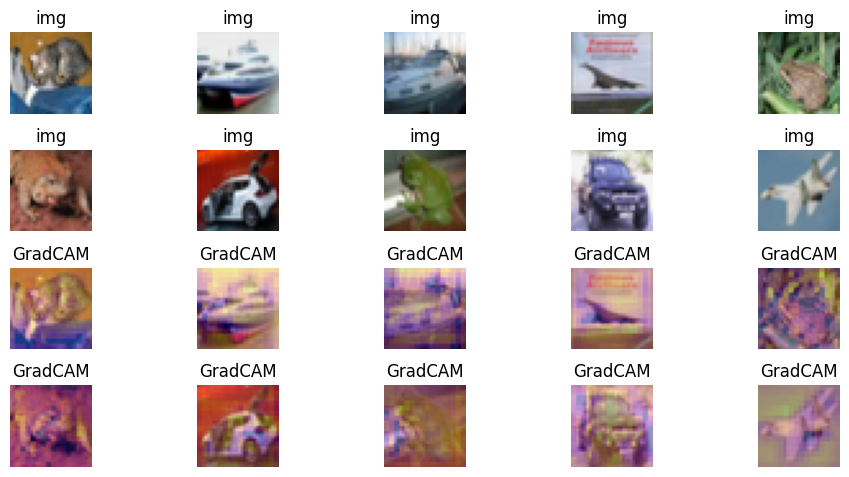

In [667]:
show_gradcam(net, samples[0])

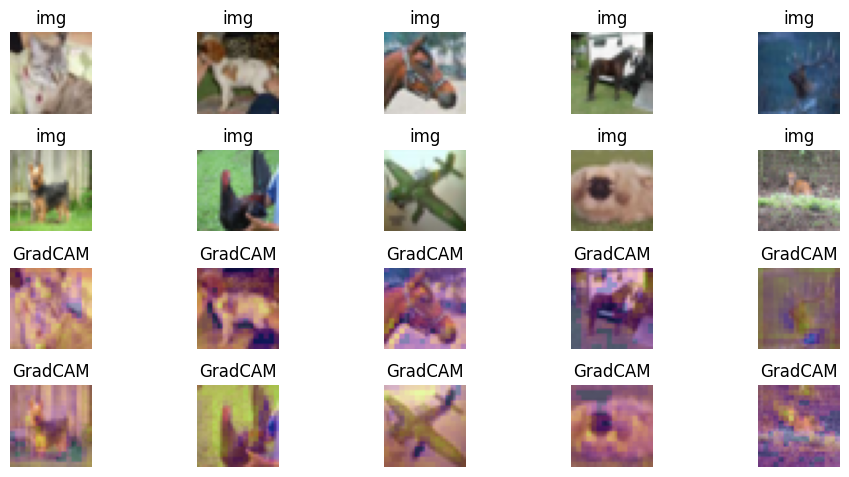

In [668]:
show_gradcam(net, samples[1])